In [ ]:
!pip install pandas numpy
!pip install matplotlib
!pip install geopandas
!pip install folium
!pip install geopy
!pip install scikit-learn

In [18]:

!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.5 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import glob
import os
import re

import matplotlib.pyplot as plt

import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap

from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import LabelEncoder, StandardScaler



## Deep Learning Model

In [2]:
combined_df_model = pd.read_csv("Deep_Learning_Input.csv")

In [3]:
def reduce_mem(df):
    for col in df.select_dtypes(include=["float64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="float")
    for col in df.select_dtypes(include=["int64"]).columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")
    return df


In [4]:
# Assuming combined_df_model is already loaded
combined_df_model = reduce_mem(combined_df_model)

# Define target
target_col = "Local dBm"

# Site-level split
sites = combined_df_model["Site name"].unique()
train_sites, test_sites = train_test_split(sites, test_size=0.2, random_state=42)
train_sites, val_sites  = train_test_split(train_sites, test_size=0.25, random_state=42)  # ~60/20/20 split

In [5]:
def filter_by_sites(df, site_list):
    return df[df["Site name"].isin(site_list)]

train_df = filter_by_sites(combined_df_model, train_sites)
val_df   = filter_by_sites(combined_df_model, val_sites)
test_df  = filter_by_sites(combined_df_model, test_sites)

In [6]:
# Site name (embedding later)
site_encoder = LabelEncoder()
combined_df_model["SiteID"] = site_encoder.fit_transform(combined_df_model["Site name"])

# Apply to splits
train_df["SiteID"] = site_encoder.transform(train_df["Site name"])
val_df["SiteID"]   = site_encoder.transform(val_df["Site name"])
test_df["SiteID"]  = site_encoder.transform(test_df["Site name"])

# Drop unused columns
drop_cols = ["Site name", "datetime", target_col]  # drop strings & target
feature_cols = [c for c in combined_df_model.columns if c not in drop_cols]

X_train, y_train = train_df[feature_cols], train_df[target_col]
X_val, y_val     = val_df[feature_cols], val_df[target_col]
X_test, y_test   = test_df[feature_cols], test_df[target_col]

# Scale numeric features (except SiteID)
scaler = StandardScaler()
num_cols = [c for c in feature_cols if c != "SiteID"]

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])


/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_8733/3337553155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["SiteID"] = site_encoder.transform(train_df["Site name"])
/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_8733/3337553155.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["SiteID"]   = site_encoder.transform(val_df["Site name"])
/var/folders/6_/lnnlyvg97bv1fbtwyqqth9z80000gn/T/ipykernel_8733/3337553155.py:8: SettingWithCopyWarning: 
A value is trying to

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable all GPUs

import tensorflow as tf
print(tf.__version__)

2.20.0


In [8]:
!pip install tensorflow
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.config.set_visible_devices([], 'GPU')
batch_size = 1024

def make_dataset(X, y, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train)
val_ds   = make_dataset(X_val, y_val, shuffle=False)
test_ds  = make_dataset(X_test, y_test, shuffle=False)


In [9]:
# from sklearn.model_selection import train_test_split
# from tensorflow.keras import layers, models
# import tensorflow as tf

# # --- 1. Map SiteID to 0-based indices ---
# site_mapping = {v: i for i, v in enumerate(sorted(X_train["SiteID"].unique()))}
# X_train["SiteID_mapped"] = X_train["SiteID"].map(site_mapping)
# X_val = X_train.copy()  # just for demonstration; replace with your validation split
# X_val["SiteID_mapped"] = X_val["SiteID"].map(site_mapping)

# site_vocab_size = len(site_mapping)

# # --- 2. Inputs ---
# inputs = {col: layers.Input(name=col, shape=(), dtype="float32") for col in num_cols}
# inputs["SiteID"] = layers.Input(name="SiteID", shape=(), dtype="int32")

# # --- 3. Site embedding ---
# site_embed = layers.Embedding(input_dim=site_vocab_size, output_dim=8)(inputs["SiteID"])
# site_embed = layers.Flatten()(site_embed)

# # --- 4. Expand numeric inputs and concatenate ---
# numeric_inputs = [layers.Lambda(lambda x: tf.expand_dims(x, -1))(inputs[col]) for col in num_cols]
# x = layers.Concatenate(axis=-1)([*numeric_inputs, site_embed])

# # --- 5. Dense layers ---
# x = layers.Dense(64, activation="relu")(x)
# x = layers.Dropout(0.3)(x)
# x = layers.Dense(32, activation="relu")(x)
# outputs = layers.Dense(1)(x)

# # --- 6. Create and compile model ---
# model = models.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer="adam", loss="mse", metrics=["mae"])
# model.summary()

# # --- 7. Prepare inputs as dictionary for training ---
# train_inputs = {col: X_train[col].values for col in num_cols}
# train_inputs["SiteID"] = X_train["SiteID_mapped"].values

# val_inputs = {col: X_val[col].values for col in num_cols}
# val_inputs["SiteID"] = X_val["SiteID_mapped"].values

# # --- 8. Train model ---
# history = model.fit(
#     train_inputs,
#     y_train.values,      # your target
#     validation_data=(val_inputs, y_train.values),  # replace with proper val target
#     epochs=50,
#     batch_size=32,
#     verbose=1
# )

In [10]:
# assert len(X_train) == len(y_train), "Mismatch between X_train and y_train!"

# n_samples = train_inputs[0].shape[0] if isinstance(train_inputs, list) else list(train_inputs.values())[0].shape[0]
# assert n_samples == len(y_train), "Mismatch after feature engineering!"

In [11]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.legend()
# plt.show()

# plt.plot(history.history['mae'], label='Train MAE')
# plt.plot(history.history['val_mae'], label='Val MAE')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.legend()
# plt.show()

=== DATA VALIDATION ===
Original data check:
X_train NaN: 0, Inf: 0
y_train NaN: 0, Inf: 0
Training samples: 1449604, Test samples: 407092

=== FEATURES ===
Using 8 features: ['Adjusted e.i.r.p. (dBm)', 'Frequency (MHz)', 'Tx_Rx_distance_km', 'Rx antenna height (m)', 'Tx antenna height (m)', 'System noise floor (dBm)', 'Site latitude', 'Site longitude']
Scaled Train shape: (1449604, 8), Test shape: (407092, 8)
Target mean=-84.68, std=19.12
Site vocab size: 3

=== BUILDING MODEL ===


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ site_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 8)      │         24 │ site_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 8)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16)        │          0 │ numeric[0][0],    │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 128)       │      2,176 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_36[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_37[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │      2,080 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │         33 │ dense_38[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,337 (52.10 KB)

 Trainable params: 12,953 (50.60 KB)

 Non-trainable params: 384 (1.50 KB)


=== TRAINING NN ===
Epoch 1/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 9s 702us/step - loss: 0.4076 - mae: 0.4941 - val_loss: 8.4294 - val_mae: 2.2287 - learning_rate: 0.0010
Epoch 2/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 706us/step - loss: 0.3809 - mae: 0.4785 - val_loss: 0.9294 - val_mae: 0.7917 - learning_rate: 0.0010
Epoch 3/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 698us/step - loss: 0.3759 - mae: 0.4751 - val_loss: 2.0572 - val_mae: 1.1086 - learning_rate: 0.0010
Epoch 4/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 731us/step - loss: 0.3735 - mae: 0.4734 - val_loss: 2.5964 - val_mae: 1.2302 - learning_rate: 0.0010
Epoch 5/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 729us/step - loss: 0.3728 - mae: 0.4726 - val_loss: 1.2009 - val_mae: 0.8097 - learning_rate: 0.0010
Epoch 6/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 718us/step - loss: 0.3716 - mae: 0.4718 - val_loss: 0.9059 - val_mae: 0.7146 - learning_rate: 0.0010
Epoch 7/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 726us/step - loss: 0.3704 - mae: 0.47

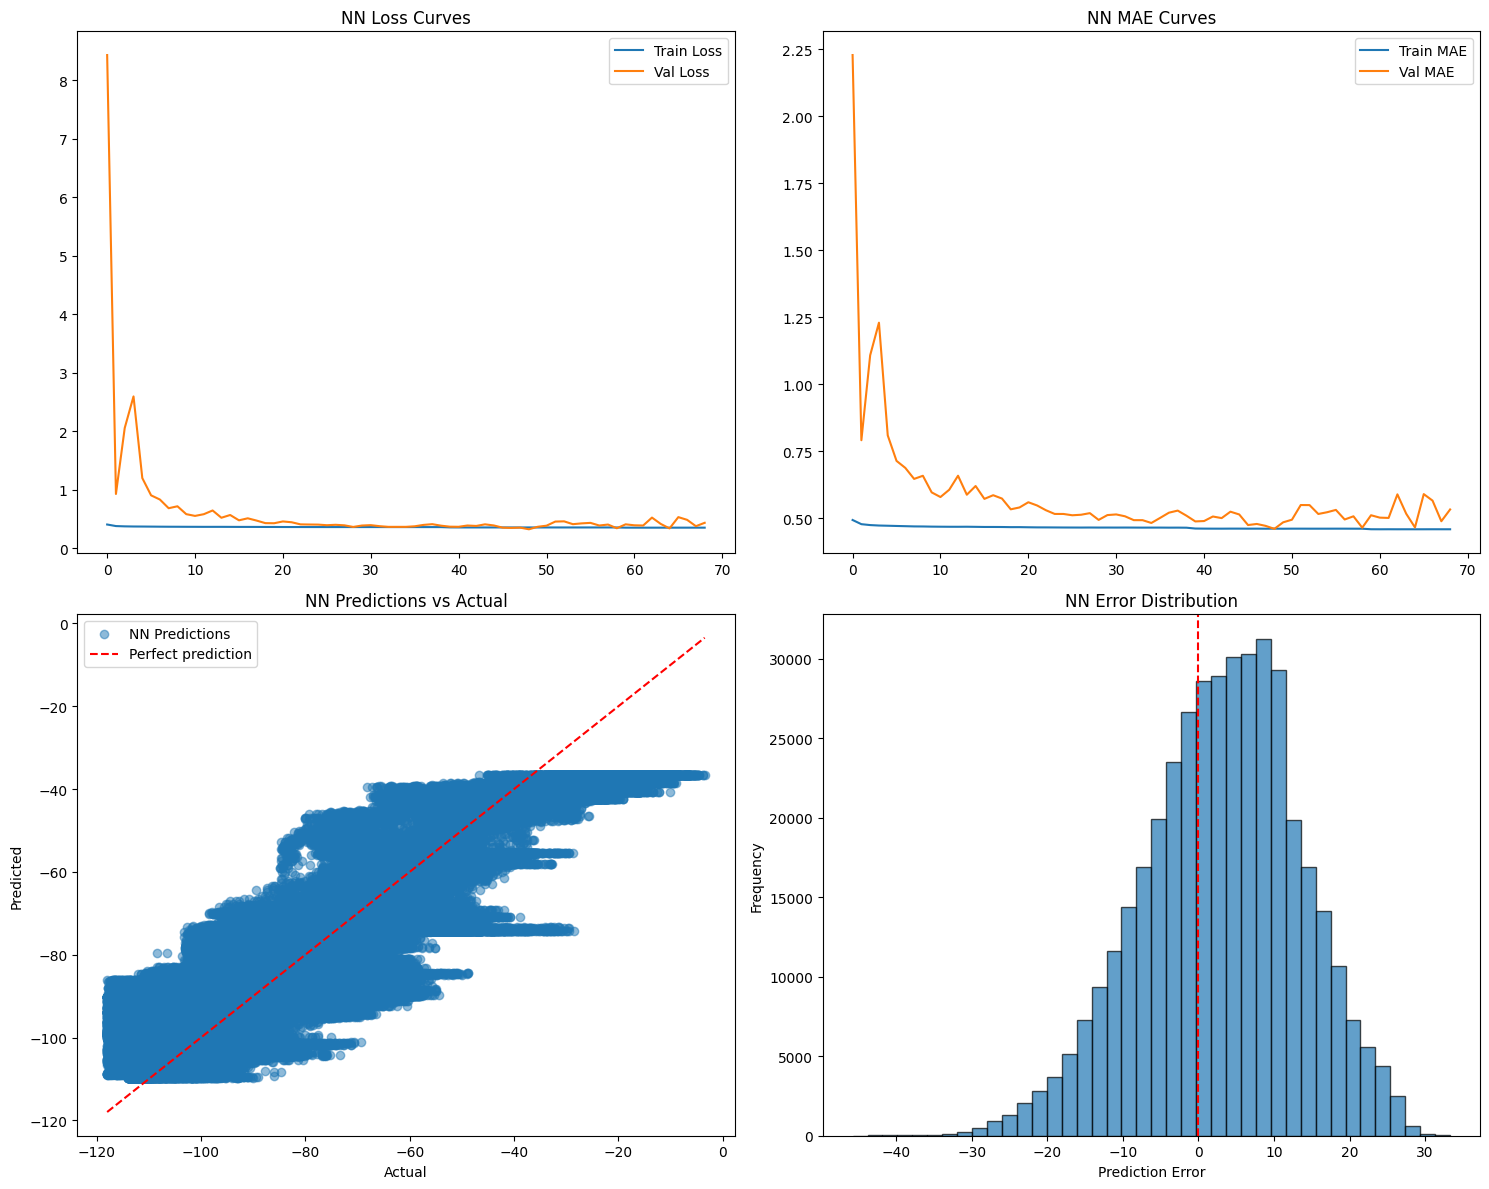


=== FINAL RESULTS ===
NN MAE=8.815, MSE=117.963
LR MAE=10.732, MSE=188.568
RF MAE=9.888, MSE=155.023
XGB MAE=10.507, MSE=171.467
=== COMPLETED ===


In [21]:
# -------------------------------
# 1. Imports
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 2. DATA DEBUGGING AND VALIDATION
# -------------------------------
print("=== DATA VALIDATION ===")

X_full = X_train.copy()
y_full = y_train.copy()

# Check for NaN/Inf
print("Original data check:")
print(f"X_train NaN: {X_train.isna().sum().sum()}, Inf: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"y_train NaN: {y_train.isna().sum().sum()}, Inf: {np.isinf(y_train).sum().sum()}")

# Basic cleaning
X_full = X_full.fillna(0)
y_full = y_full.fillna(y_full.mean())

# Site-based split
all_sites = sorted(X_full["SiteID"].unique())
n_train_sites = int(len(all_sites) * 0.8)
train_sites = all_sites[:n_train_sites]
test_sites = all_sites[n_train_sites:]

X_train_split = X_full[X_full["SiteID"].isin(train_sites)].copy()
y_train_split = y_full[X_full["SiteID"].isin(train_sites)].copy()
X_test_split = X_full[X_full["SiteID"].isin(test_sites)].copy()
y_test_split = y_full[X_full["SiteID"].isin(test_sites)].copy()

print(f"Training samples: {len(X_train_split)}, Test samples: {len(X_test_split)}")

# -------------------------------
# 3. FEATURES
# -------------------------------
print("\n=== FEATURES ===")

num_cols = [
    "Adjusted e.i.r.p. (dBm)",
    "Frequency (MHz)", 
    "Tx_Rx_distance_km",
    "Rx antenna height (m)",
    "Tx antenna height (m)",
    "System noise floor (dBm)",
    "Site latitude",
    "Site longitude"
]
num_cols = [c for c in num_cols if c in X_train_split.columns]
print(f"Using {len(num_cols)} features: {num_cols}")

# Clip outliers
for col in num_cols:
    low, high = X_train_split[col].quantile([0.01, 0.99])
    X_train_split[col] = np.clip(X_train_split[col], low, high)
    X_test_split[col] = np.clip(X_test_split[col], low, high)

# -------------------------------
# 4. SCALING
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split[num_cols])
X_test_scaled = scaler.transform(X_test_split[num_cols])
X_train_scaled = np.nan_to_num(X_train_scaled.astype(np.float32))
X_test_scaled = np.nan_to_num(X_test_scaled.astype(np.float32))
print(f"Scaled Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

# -------------------------------
# 5. TARGET
# -------------------------------
y_train_values = y_train_split.values.astype(np.float32)
y_test_values = y_test_split.values.astype(np.float32)

# Standardize target
y_mean, y_std = y_train_values.mean(), y_train_values.std()
y_train_scaled = (y_train_values - y_mean) / y_std
y_test_scaled = (y_test_values - y_mean) / y_std

print(f"Target mean={y_mean:.2f}, std={y_std:.2f}")

# -------------------------------
# 6. SITE EMBEDDING
# -------------------------------
site_mapping = {v: i+1 for i, v in enumerate(sorted(train_sites))}  # +1 for padding
X_train_site = X_train_split["SiteID"].map(site_mapping).fillna(0).astype(int).values
X_test_site = X_test_split["SiteID"].map(site_mapping).fillna(0).astype(int).values
site_vocab_size = len(site_mapping) + 1
print(f"Site vocab size: {site_vocab_size}")

# -------------------------------
# 7. IMPROVED MODEL
# -------------------------------
print("\n=== BUILDING MODEL ===")

num_input = layers.Input(shape=(X_train_scaled.shape[1],), name="numeric")
site_input = layers.Input(shape=(1,), name="site_id")

site_embed = layers.Embedding(input_dim=site_vocab_size, output_dim=8)(site_input)
site_embed = layers.Flatten()(site_embed)

x = layers.Concatenate()([num_input, site_embed])
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)

model = models.Model(inputs=[num_input, site_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()

# -------------------------------
# 8. TRAINING
# -------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

print("\n=== TRAINING NN ===")
history = model.fit(
    {"numeric": X_train_scaled, "site_id": X_train_site},
    y_train_scaled,
    validation_data=({"numeric": X_test_scaled, "site_id": X_test_site}, y_test_scaled),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -------------------------------
# 9. EVALUATION (NN)
# -------------------------------
print("\n=== EVALUATION NN ===")
nn_preds_scaled = model.predict({"numeric": X_test_scaled, "site_id": X_test_site}, verbose=0).flatten()
nn_preds = nn_preds_scaled * y_std + y_mean

nn_mae = mean_absolute_error(y_test_values, nn_preds)
nn_mse = mean_squared_error(y_test_values, nn_preds)
print(f"NN Test MAE: {nn_mae:.3f}, MSE: {nn_mse:.3f}")

# -------------------------------
# 10. BASELINES
# -------------------------------
print("\n=== BASELINES ===")

# Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_train_values)
lr_preds = lr.predict(X_test_scaled)
lr_mae = mean_absolute_error(y_test_values, lr_preds)
lr_mse = mean_squared_error(y_test_values, lr_preds)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train_values)
rf_preds = rf.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test_values, rf_preds)
rf_mse = mean_squared_error(y_test_values, rf_preds)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train_values, eval_set=[(X_test_scaled, y_test_values)], verbose=False)
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test_values, xgb_preds)
xgb_mse = mean_squared_error(y_test_values, xgb_preds)

print(f"Linear Regression: MAE={lr_mae:.3f}, MSE={lr_mse:.3f}")
print(f"Random Forest:     MAE={rf_mae:.3f}, MSE={rf_mse:.3f}")
print(f"XGBoost:           MAE={xgb_mae:.3f}, MSE={xgb_mse:.3f}")

# -------------------------------
# 11. PLOTTING
# -------------------------------
print("\n=== PLOTTING ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title("NN Loss Curves")
ax1.legend()

# MAE curves
ax2.plot(history.history['mae'], label='Train MAE')
ax2.plot(history.history['val_mae'], label='Val MAE')
ax2.set_title("NN MAE Curves")
ax2.legend()

# Predictions vs Actual (NN)
ax3.scatter(y_test_values, nn_preds, alpha=0.5, label="NN Predictions")
lims = [min(y_test_values.min(), nn_preds.min()), max(y_test_values.max(), nn_preds.max())]
ax3.plot(lims, lims, 'r--', label="Perfect prediction")
ax3.set_xlabel("Actual")
ax3.set_ylabel("Predicted")
ax3.legend()
ax3.set_title("NN Predictions vs Actual")

# Error distribution (NN)
errors = nn_preds - y_test_values
ax4.hist(errors, bins=40, edgecolor="black", alpha=0.7)
ax4.axvline(0, color="r", linestyle="--")
ax4.set_title("NN Error Distribution")
ax4.set_xlabel("Prediction Error")
ax4.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# -------------------------------
# 12. RESULTS SUMMARY
# -------------------------------
print("\n=== FINAL RESULTS ===")
print(f"NN MAE={nn_mae:.3f}, MSE={nn_mse:.3f}")
print(f"LR MAE={lr_mae:.3f}, MSE={lr_mse:.3f}")
print(f"RF MAE={rf_mae:.3f}, MSE={rf_mse:.3f}")
print(f"XGB MAE={xgb_mae:.3f}, MSE={xgb_mse:.3f}")
print("=== COMPLETED ===")

=== DATA VALIDATION ===
Original data check:
X_train NaN: 0, Inf: 0
y_train NaN: 0, Inf: 0
Training samples: 1449604, Test samples: 407092
Using 12 features: ['Adjusted e.i.r.p. (dBm)', 'Frequency (MHz)', 'Tx_Rx_distance_km', 'Rx antenna height (m)', 'Tx antenna height (m)', 'System noise floor (dBm)', 'Site latitude', 'Site longitude', 'dist_freq', 'height_diff', 'snr_proxy', 'log_distance']
Scaled Train shape: (1449604, 12), Test shape: (407092, 12)
Target mean=-84.68, std=19.12
Site vocab size: 3

=== BUILDING MODEL ===


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ site_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 8)      │         24 │ site_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 8)         │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 20)        │          0 │ numeric[0][0],    │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 128)       │      2,688 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_40[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │      8,256 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_41[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │      2,080 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1)         │         33 │ dense_42[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,849 (54.10 KB)

 Trainable params: 13,465 (52.60 KB)

 Non-trainable params: 384 (1.50 KB)


=== TRAINING NN ===
Epoch 1/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 10s 757us/step - loss: 0.4055 - mae: 0.4917 - val_loss: 6.3438 - val_mae: 1.7737 - learning_rate: 0.0010
Epoch 2/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 9s 768us/step - loss: 0.3765 - mae: 0.4747 - val_loss: 4.7385 - val_mae: 1.5376 - learning_rate: 0.0010
Epoch 3/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 743us/step - loss: 0.3723 - mae: 0.4717 - val_loss: 2.8396 - val_mae: 1.2386 - learning_rate: 0.0010
Epoch 4/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 9s 797us/step - loss: 0.3702 - mae: 0.4702 - val_loss: 3.2346 - val_mae: 1.2700 - learning_rate: 0.0010
Epoch 5/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 9s 787us/step - loss: 0.3686 - mae: 0.4689 - val_loss: 1.5683 - val_mae: 0.9378 - learning_rate: 0.0010
Epoch 6/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 8s 721us/step - loss: 0.3673 - mae: 0.4678 - val_loss: 1.3089 - val_mae: 0.8423 - learning_rate: 0.0010
Epoch 7/200
11326/11326 ━━━━━━━━━━━━━━━━━━━━ 9s 753us/step - loss: 0.3670 - mae: 0.4

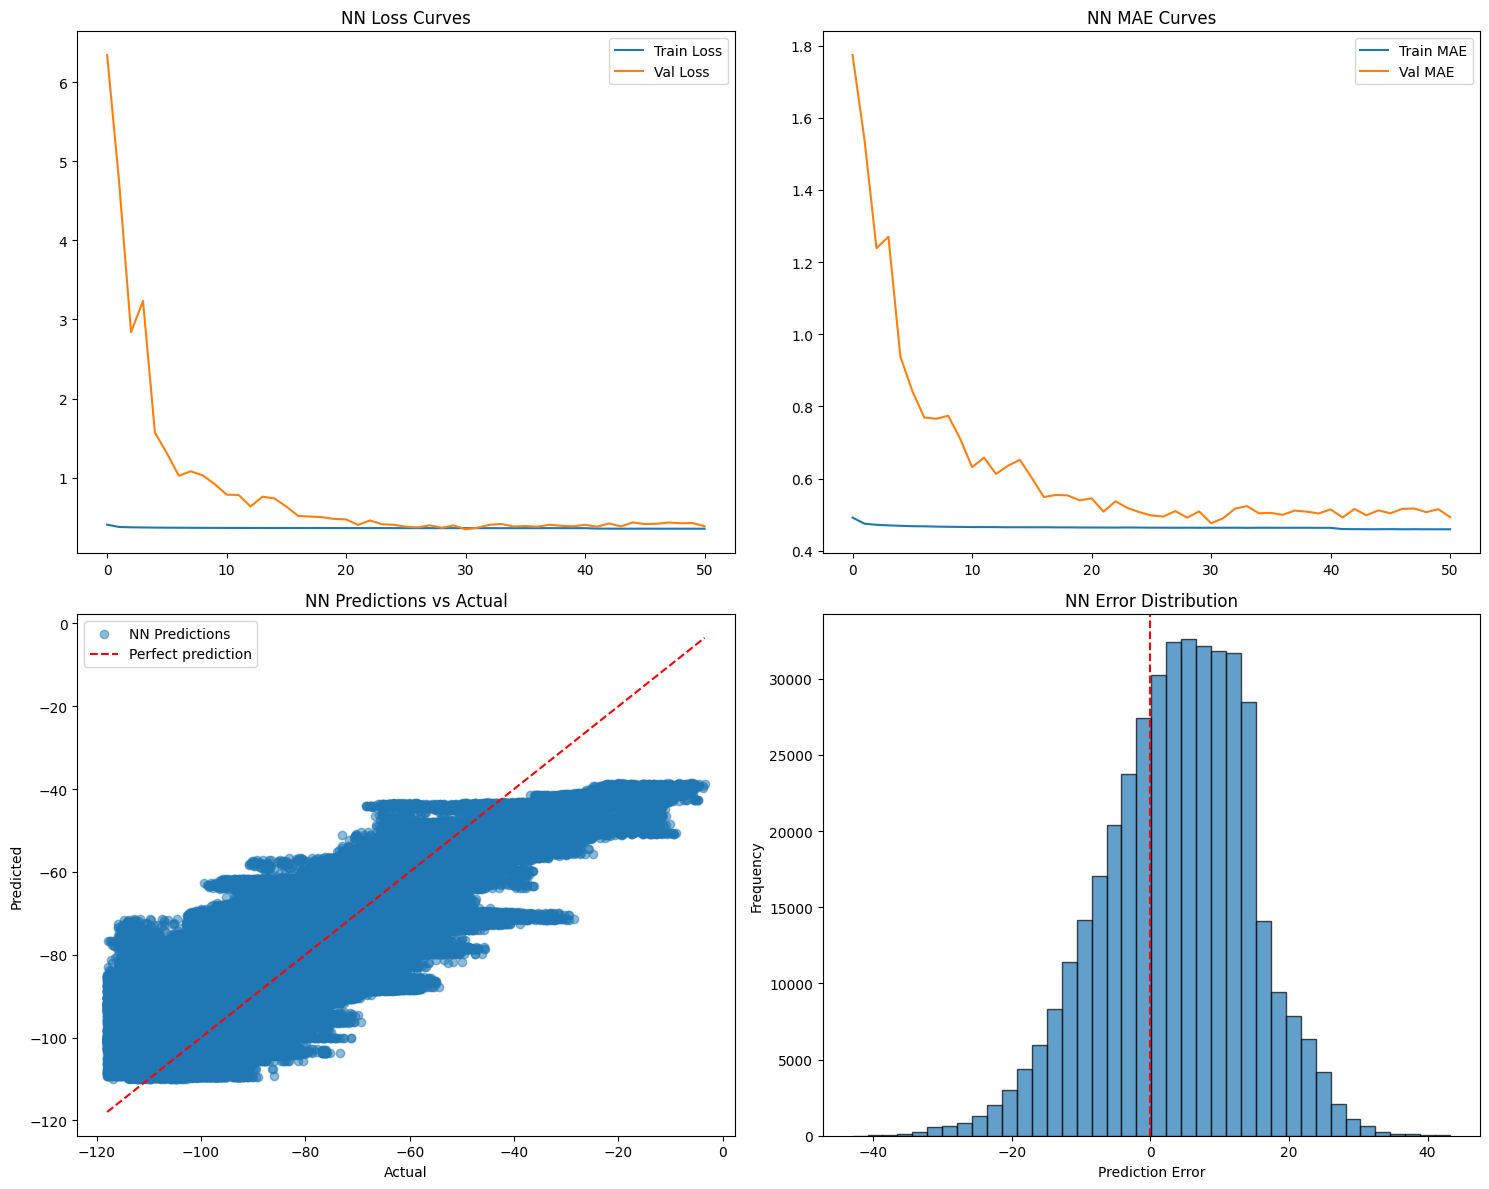


=== FINAL RESULTS ===
NN MAE=9.101, MSE=125.061
LR MAE=10.774, MSE=184.084
RF MAE=10.349, MSE=165.977
XGB MAE=11.311, MSE=195.970
=== COMPLETED ===


In [24]:
# -------------------------------
# 1. Imports
# -------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# -------------------------------
# 2. DATA DEBUGGING AND VALIDATION
# -------------------------------
print("=== DATA VALIDATION ===")

X_full = X_train.copy()
y_full = y_train.copy()

# Check for NaN/Inf
print("Original data check:")
print(f"X_train NaN: {X_train.isna().sum().sum()}, Inf: {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum()}")
print(f"y_train NaN: {y_train.isna().sum().sum()}, Inf: {np.isinf(y_train).sum().sum()}")

# Basic cleaning
X_full = X_full.fillna(0)
y_full = y_full.fillna(y_full.mean())

# Site-based split
all_sites = sorted(X_full["SiteID"].unique())
n_train_sites = int(len(all_sites) * 0.8)
train_sites = all_sites[:n_train_sites]
test_sites = all_sites[n_train_sites:]

X_train_split = X_full[X_full["SiteID"].isin(train_sites)].copy()
y_train_split = y_full[X_full["SiteID"].isin(train_sites)].copy()
X_test_split = X_full[X_full["SiteID"].isin(test_sites)].copy()
y_test_split = y_full[X_full["SiteID"].isin(test_sites)].copy()

print(f"Training samples: {len(X_train_split)}, Test samples: {len(X_test_split)}")

# -------------------------------
# 3. FEATURE ENGINEERING
# -------------------------------
def feature_engineering(df):
    if "Tx_Rx_distance_km" in df.columns and "Frequency (MHz)" in df.columns:
        df["dist_freq"] = df["Tx_Rx_distance_km"] * df["Frequency (MHz)"]
    if "Rx antenna height (m)" in df.columns and "Tx antenna height (m)" in df.columns:
        df["height_diff"] = df["Rx antenna height (m)"] - df["Tx antenna height (m)"]
    if "Adjusted e.i.r.p. (dBm)" in df.columns and "System noise floor (dBm)" in df.columns:
        df["snr_proxy"] = df["Adjusted e.i.r.p. (dBm)"] - df["System noise floor (dBm)"]
    if "Tx_Rx_distance_km" in df.columns:
        df["log_distance"] = np.log1p(df["Tx_Rx_distance_km"])
    return df

X_train_split = feature_engineering(X_train_split)
X_test_split = feature_engineering(X_test_split)

num_cols = [
    "Adjusted e.i.r.p. (dBm)",
    "Frequency (MHz)", 
    "Tx_Rx_distance_km",
    "Rx antenna height (m)",
    "Tx antenna height (m)",
    "System noise floor (dBm)",
    "Site latitude",
    "Site longitude",
    "dist_freq",
    "height_diff",
    "snr_proxy",
    "log_distance"
]
num_cols = [c for c in num_cols if c in X_train_split.columns]
print(f"Using {len(num_cols)} features: {num_cols}")

# Clip outliers
for col in num_cols:
    low, high = X_train_split[col].quantile([0.01, 0.99])
    X_train_split[col] = np.clip(X_train_split[col], low, high)
    X_test_split[col] = np.clip(X_test_split[col], low, high)

# -------------------------------
# 4. SCALING
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split[num_cols])
X_test_scaled = scaler.transform(X_test_split[num_cols])
X_train_scaled = np.nan_to_num(X_train_scaled.astype(np.float32))
X_test_scaled = np.nan_to_num(X_test_scaled.astype(np.float32))
print(f"Scaled Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

# -------------------------------
# 5. TARGET
# -------------------------------
y_train_values = y_train_split.values.astype(np.float32)
y_test_values = y_test_split.values.astype(np.float32)

y_mean, y_std = y_train_values.mean(), y_train_values.std()
y_train_scaled = (y_train_values - y_mean) / y_std
y_test_scaled = (y_test_values - y_mean) / y_std

print(f"Target mean={y_mean:.2f}, std={y_std:.2f}")

# -------------------------------
# 6. SITE EMBEDDING
# -------------------------------
site_mapping = {v: i+1 for i, v in enumerate(sorted(train_sites))}  # +1 for padding
X_train_site = X_train_split["SiteID"].map(site_mapping).fillna(0).astype(int).values
X_test_site = X_test_split["SiteID"].map(site_mapping).fillna(0).astype(int).values
site_vocab_size = len(site_mapping) + 1
print(f"Site vocab size: {site_vocab_size}")

# -------------------------------
# 7. MODEL (NN)
# -------------------------------
print("\n=== BUILDING MODEL ===")

num_input = layers.Input(shape=(X_train_scaled.shape[1],), name="numeric")
site_input = layers.Input(shape=(1,), name="site_id")

site_embed = layers.Embedding(input_dim=site_vocab_size, output_dim=8)(site_input)
site_embed = layers.Flatten()(site_embed)

x = layers.Concatenate()([num_input, site_embed])
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)

model = models.Model(inputs=[num_input, site_input], outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()

# -------------------------------
# 8. TRAINING
# -------------------------------
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-6, verbose=1)

print("\n=== TRAINING NN ===")
history = model.fit(
    {"numeric": X_train_scaled, "site_id": X_train_site},
    y_train_scaled,
    validation_data=({"numeric": X_test_scaled, "site_id": X_test_site}, y_test_scaled),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# -------------------------------
# 9. EVALUATION (NN)
# -------------------------------
print("\n=== EVALUATION NN ===")
nn_preds_scaled = model.predict({"numeric": X_test_scaled, "site_id": X_test_site}, verbose=0).flatten()
nn_preds = nn_preds_scaled * y_std + y_mean

nn_mae = mean_absolute_error(y_test_values, nn_preds)
nn_mse = mean_squared_error(y_test_values, nn_preds)
print(f"NN Test MAE: {nn_mae:.3f}, MSE: {nn_mse:.3f}")

# -------------------------------
# 10. BASELINES
# -------------------------------
print("\n=== BASELINES ===")

# Linear Regression
lr = LinearRegression().fit(X_train_scaled, y_train_values)
lr_preds = lr.predict(X_test_scaled)
lr_mae = mean_absolute_error(y_test_values, lr_preds)
lr_mse = mean_squared_error(y_test_values, lr_preds)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train_values)
rf_preds = rf.predict(X_test_scaled)
rf_mae = mean_absolute_error(y_test_values, rf_preds)
rf_mse = mean_squared_error(y_test_values, rf_preds)

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=8,
                             subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_scaled, y_train_values, eval_set=[(X_test_scaled, y_test_values)], verbose=False)
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_mae = mean_absolute_error(y_test_values, xgb_preds)
xgb_mse = mean_squared_error(y_test_values, xgb_preds)

print(f"Linear Regression: MAE={lr_mae:.3f}, MSE={lr_mse:.3f}")
print(f"Random Forest:     MAE={rf_mae:.3f}, MSE={rf_mse:.3f}")
print(f"XGBoost:           MAE={xgb_mae:.3f}, MSE={xgb_mse:.3f}")

# -------------------------------
# 11. PLOTTING
# -------------------------------
print("\n=== PLOTTING ===")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title("NN Loss Curves")
ax1.legend()

# MAE curves
ax2.plot(history.history['mae'], label='Train MAE')
ax2.plot(history.history['val_mae'], label='Val MAE')
ax2.set_title("NN MAE Curves")
ax2.legend()

# Predictions vs Actual (NN)
ax3.scatter(y_test_values, nn_preds, alpha=0.5, label="NN Predictions")
lims = [min(y_test_values.min(), nn_preds.min()), max(y_test_values.max(), nn_preds.max())]
ax3.plot(lims, lims, 'r--', label="Perfect prediction")
ax3.set_xlabel("Actual")
ax3.set_ylabel("Predicted")
ax3.legend()
ax3.set_title("NN Predictions vs Actual")

# Error distribution (NN)
errors = nn_preds - y_test_values
ax4.hist(errors, bins=40, edgecolor="black", alpha=0.7)
ax4.axvline(0, color="r", linestyle="--")
ax4.set_title("NN Error Distribution")
ax4.set_xlabel("Prediction Error")
ax4.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# -------------------------------
# 12. RESULTS SUMMARY
# -------------------------------
print("\n=== FINAL RESULTS ===")
print(f"NN MAE={nn_mae:.3f}, MSE={nn_mse:.3f}")
print(f"LR MAE={lr_mae:.3f}, MSE={lr_mse:.3f}")
print(f"RF MAE={rf_mae:.3f}, MSE={rf_mse:.3f}")
print(f"XGB MAE={xgb_mae:.3f}, MSE={xgb_mse:.3f}")
print("=== COMPLETED ===")